✅ Dataset loaded successfully!
Train Shape: (320, 200, 128), Val Shape: (80, 200, 128)
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.2502 - loss: 2.1597 - val_accuracy: 0.4125 - val_loss: 1.5155
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5053 - loss: 1.4650 - val_accuracy: 0.5875 - val_loss: 1.1022
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6274 - loss: 1.1451 - val_accuracy: 0.6250 - val_loss: 1.0859
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6185 - loss: 1.0070 - val_accuracy: 0.6000 - val_loss: 0.9763
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6573 - loss: 0.8625 - val_accuracy: 0.6500 - val_loss: 1.0388
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7433 - loss: 0.7347 - val_accuracy: 0.7375 - val_loss: 0.9523
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7723 - loss: 0.6855 - val_accuracy: 0.6375 - val_loss: 0.9893
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0

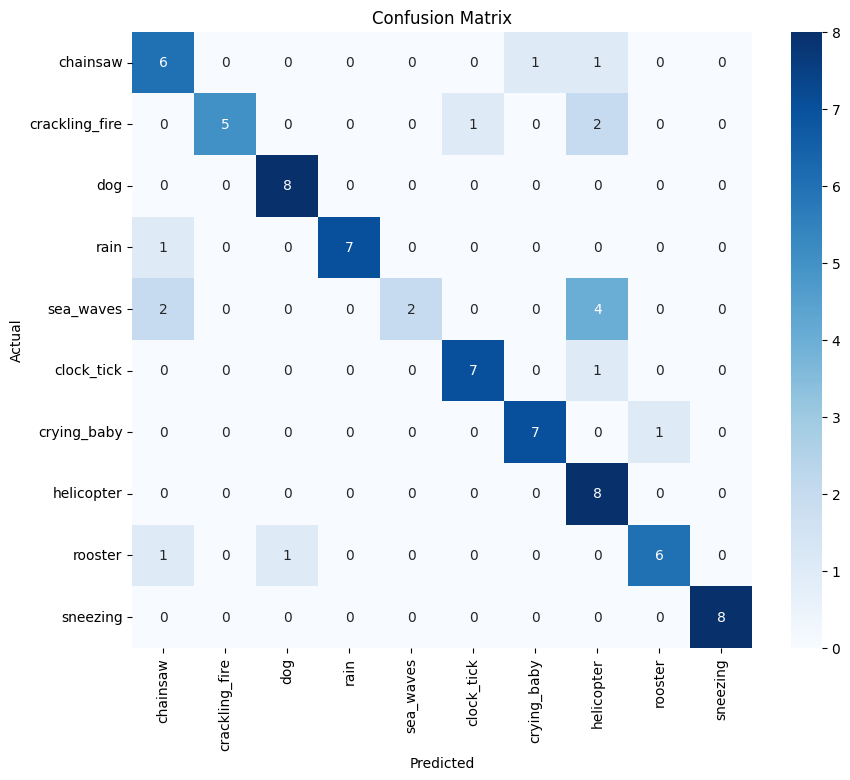


Classification Report:
                 precision    recall  f1-score   support

      chainsaw       0.60      0.75      0.67         8
crackling_fire       1.00      0.62      0.77         8
           dog       0.89      1.00      0.94         8
          rain       1.00      0.88      0.93         8
     sea_waves       1.00      0.25      0.40         8
    clock_tick       0.88      0.88      0.88         8
   crying_baby       0.88      0.88      0.88         8
    helicopter       0.50      1.00      0.67         8
       rooster       0.86      0.75      0.80         8
      sneezing       1.00      1.00      1.00         8

      accuracy                           0.80        80
     macro avg       0.86      0.80      0.79        80
  weighted avg       0.86      0.80      0.79        80



In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix, classification_report

# ✅ Constants
SAMPLE_RATE = 16000
N_MELS = 128
MAX_TIME_STEPS = 200  # ✅ Fixed length for spectrograms
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
EPOCHS = 50  # 🔥 Reduced from 50 to 30 to prevent overfitting
CLASSES = ['chainsaw', 'crackling_fire', 'dog', 'rain', 'sea_waves', 
           'clock_tick', 'crying_baby', 'helicopter', 'rooster', 'sneezing']
NUM_CLASSES = len(CLASSES)

# ✅ Convert WAV to Log-Mel Spectrogram
def get_mel_spectrogram(file_path):
    try:
        # Load WAV file using Librosa (automatically converts all formats)
        audio, _ = librosa.load(file_path, sr=SAMPLE_RATE)

        # Compute Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, 
                                                         n_mels=N_MELS, n_fft=1024, hop_length=512)

        # Convert to log scale (avoiding log(0) issue)
        log_mel_spectrogram = np.log(mel_spectrogram + 1e-9)

        return log_mel_spectrogram.T  # ✅ Fix: Transpose to (time_steps, n_mels)

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None  # Skip invalid files

# ✅ Pad or truncate spectrograms to MAX_TIME_STEPS
def pad_or_truncate(spectrogram):
    if spectrogram.shape[0] > MAX_TIME_STEPS:
        return spectrogram[:MAX_TIME_STEPS, :]  # Truncate
    else:
        return np.pad(spectrogram, ((0, MAX_TIME_STEPS - spectrogram.shape[0]), (0, 0)), mode="constant")

# ✅ Load Dataset
def load_dataset(root_dir, augment=False):
    spectrograms, labels = [], []

    for idx, class_name in enumerate(CLASSES):
        class_dir = os.path.join(root_dir, class_name)
        if not os.path.exists(class_dir):
            continue

        for file_name in os.listdir(class_dir):
            if file_name.endswith(".wav"):
                file_path = os.path.join(class_dir, file_name)
                
                mel_spec = get_mel_spectrogram(file_path)

                # ✅ Ensure valid spectrogram and apply padding/truncation
                if isinstance(mel_spec, np.ndarray):
                    mel_spec = pad_or_truncate(mel_spec)  # Fix shape
                    spectrograms.append(mel_spec)
                    labels.append(idx)

    return np.array(spectrograms), np.array(labels)

# Load data
data_spectrograms, data_labels = load_dataset('/kaggle/input/esc10rearranged/Data')

# Split into training (80%) and test (20%)
train_spectrograms, val_spectrograms, train_labels, val_labels = train_test_split(
    data_spectrograms, data_labels, test_size=0.2, random_state=42, stratify=data_labels
)

# ✅ Normalize Data
mean = np.mean(train_spectrograms)
std = np.std(train_spectrograms)

train_spectrograms = (train_spectrograms - mean) / std
val_spectrograms = (val_spectrograms - mean) / std

print("✅ Dataset loaded successfully!")
print(f"Train Shape: {train_spectrograms.shape}, Val Shape: {val_spectrograms.shape}")

# ✅ Define TimeScaleNet Model
def BiquadNet(input_tensor):
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0))(input_tensor)  # 🔥 Increased Dropout
    x = layers.LayerNormalization()(x)
    return x

def FrameNet(input_tensor):
    # Atrous Convolutions
    x = layers.Conv1D(128, kernel_size=3, padding="same", dilation_rate=1, activation="relu")(input_tensor)
    x = layers.Conv1D(128, kernel_size=3, padding="same", dilation_rate=2, activation="relu")(x)
    x = layers.Conv1D(128, kernel_size=3, padding="same", dilation_rate=4, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    # Self-Attention Mechanism
    attention = layers.MultiHeadAttention(num_heads=4, key_dim=128)(x, x)
    x = layers.Add()([x, attention])
    x = layers.LayerNormalization()(x)
    
    # Global Pooling
    x = layers.GlobalAveragePooling1D()(x)
    return x

def TimeScaleNet():
    input_tensor = layers.Input(shape=(MAX_TIME_STEPS, N_MELS))  # ✅ Fixed shape

    lstm_out = BiquadNet(input_tensor)
    frame_features = FrameNet(lstm_out)

    output = layers.Dense(NUM_CLASSES, activation="softmax")(frame_features)

    return models.Model(inputs=input_tensor, outputs=output)

# ✅ Compile Model
model = TimeScaleNet()
model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ✅ Add Callbacks to Reduce Overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9638 - loss: 0.0987 - val_accuracy: 0.8625 - val_loss: 0.7097
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9299 - loss: 0.2466 - val_accuracy: 0.8125 - val_loss: 0.5644
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9445 - loss: 0.1836 - val_accuracy: 0.7500 - val_loss: 0.7972
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9447 - loss: 0.1543 - val_accuracy: 0.8625 - val_loss: 0.5100
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9678 - loss: 0.0876 - val_accuracy: 0.8000 - val_loss: 0.5396
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9835 - loss: 0.0576 - val_accuracy: 0.8250 - val_loss: 0.4949
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9944 - loss: 0.0207 - val_accuracy: 0.8625 - val_loss: 0.4589
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0183 - val_accuracy: 0.8625 - val_loss: 0.4542


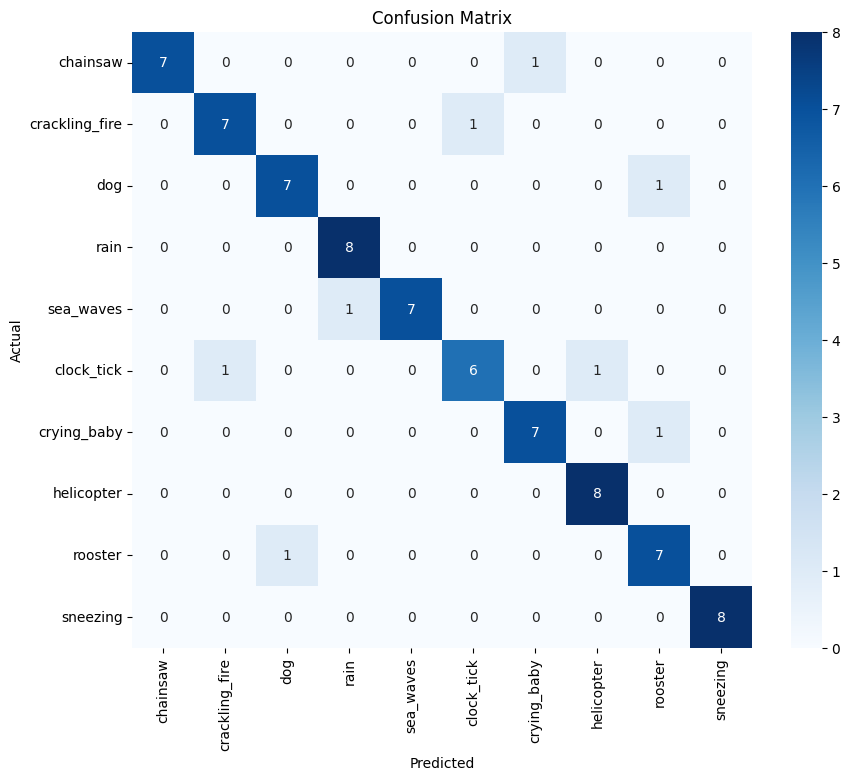


Classification Report:
                 precision    recall  f1-score   support

      chainsaw       1.00      0.88      0.93         8
crackling_fire       0.88      0.88      0.88         8
           dog       0.88      0.88      0.88         8
          rain       0.89      1.00      0.94         8
     sea_waves       1.00      0.88      0.93         8
    clock_tick       0.86      0.75      0.80         8
   crying_baby       0.88      0.88      0.88         8
    helicopter       0.89      1.00      0.94         8
       rooster       0.78      0.88      0.82         8
      sneezing       1.00      1.00      1.00         8

      accuracy                           0.90        80
     macro avg       0.90      0.90      0.90        80
  weighted avg       0.90      0.90      0.90        80



In [2]:
# ✅ Train the Model
history = model.fit(
    train_spectrograms, train_labels,
    epochs=EPOCHS,  # 🔥 Reduced from 50 to 30
    batch_size=BATCH_SIZE,
    validation_data=(val_spectrograms, val_labels)  # 🔥 Added callbacks to stop training early
)

# ✅ Save the trained model
model.save("/kaggle/working/timescalenet_model.h5")
print("✅ Model saved successfully!")

# ✅ Evaluate Model Performance
val_preds = np.argmax(model.predict(val_spectrograms), axis=1)

# ✅ Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ Classification Report
print("\nClassification Report:\n", classification_report(val_labels, val_preds, target_names=CLASSES))

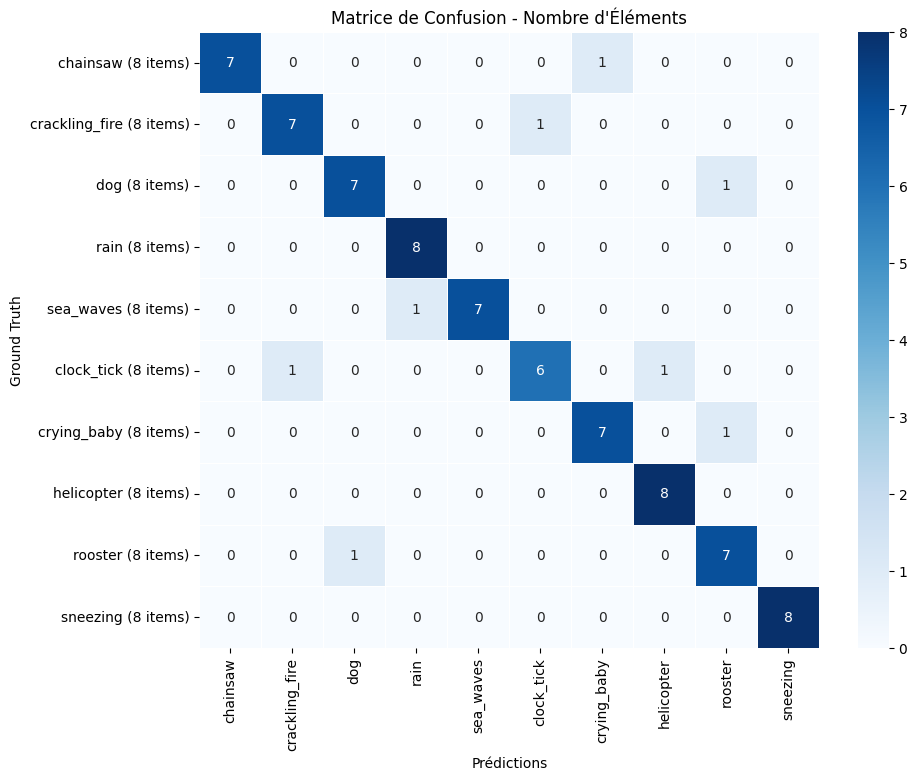

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
 
# ✅ Calcul de la matrice de confusion brute (nombre d'éléments par classe)
cm = confusion_matrix(val_labels, val_preds)
 
# ✅ Tracer la matrice avec les nombres d'éléments uniquement
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, 
            xticklabels=CLASSES, yticklabels=[f"{CLASSES[i]} ({cm[i].sum()} items)" for i in range(len(CLASSES))], cbar=True)
 
# ✅ Ajouter les axes et le titre
plt.xlabel("Prédictions")
plt.ylabel("Ground Truth")
plt.title("Matrice de Confusion - Nombre d'Éléments")
plt.show()

In [4]:
# ✅ Save the trained model
model.save("/kaggle/working/timescalenet_model.h5")
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ✅ Prédictions sur le jeu de validation
val_predictions = np.argmax(model.predict(val_spectrograms), axis=1)

# ✅ Calcul des métriques
accuracy = accuracy_score(val_labels, val_predictions)
precision = precision_score(val_labels, val_predictions, average="macro")
recall = recall_score(val_labels, val_predictions, average="macro")
f1 = f1_score(val_labels, val_predictions, average="macro")

# ✅ Affichage des résultats
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1:.2%}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 90.00%
Precision: 90.38%
Recall: 90.00%
F1 Score: 89.98%


**Courbes de perte et d'exactitude (training vs validation) :** 
Visualiser la performance du modèle au fil des époques.

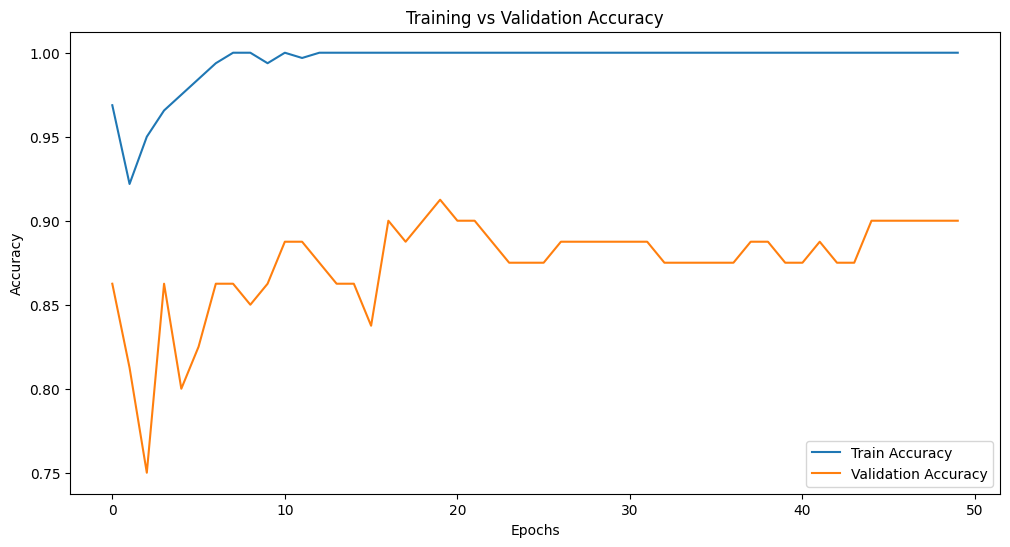

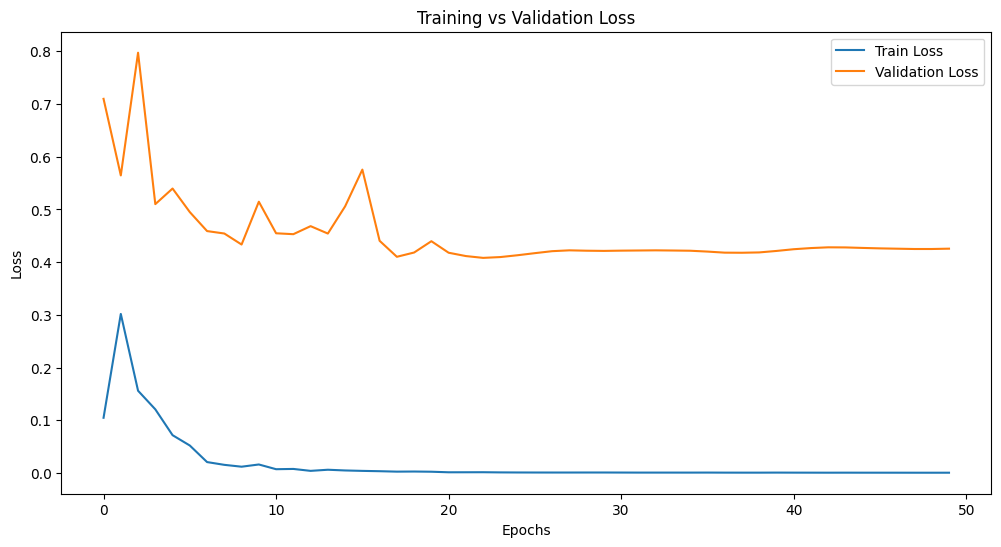

In [6]:
# ✅ Courbes de performance
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [11]:
pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


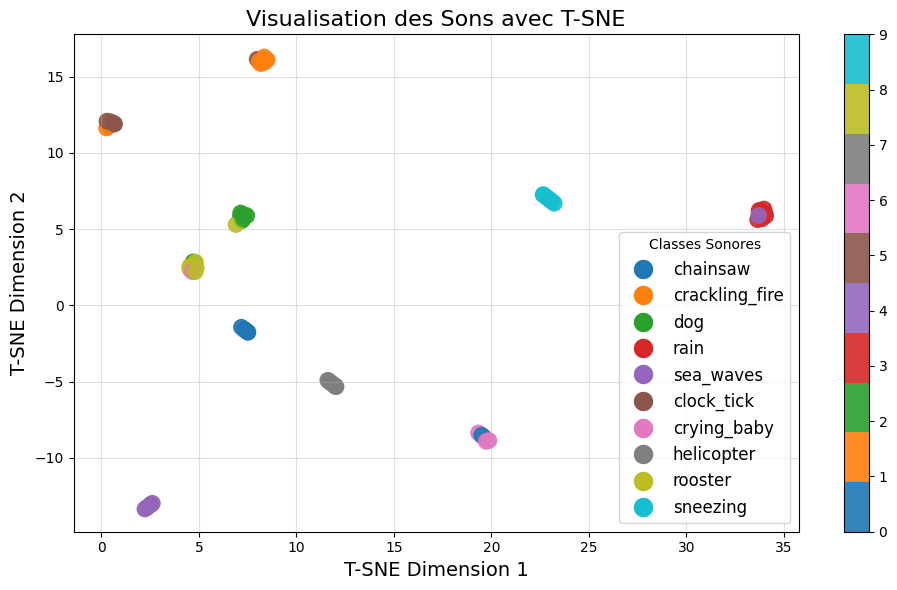

In [22]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# ✅ Initialisation de UMAP avec des paramètres optimisés
umap_model = umap.UMAP(
    n_neighbors=15,      # 🔥 Contrôle la balance locale/globale
    min_dist=0.1,        # 🔥 Distance minimale entre les points
    n_components=2,      # Réduction à 2 dimensions
    random_state=42
)

# ✅ Réduction de dimension avec UMAP
X_umap = umap_model.fit_transform(model.predict(val_spectrograms))

# ✅ Affichage des points en 2D
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_umap[:, 0], X_umap[:, 1], 
    c=val_labels, cmap="tab10", alpha=0.9, s=120  # 🔥 Taille des points augmentée (s=120)
)

# ✅ Légende et noms des classes
legend_labels = {i: CLASSES[i] for i in range(NUM_CLASSES)}
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=15,  # 🔥 Taille des pastilles de légende augmentée
                       markerfacecolor=scatter.cmap(scatter.norm(i))) 
           for i in range(NUM_CLASSES)]
plt.legend(handles, legend_labels.values(), title="Classes Sonores", loc="best", fontsize=12)

# ✅ Configuration des axes et de la grille
plt.colorbar(scatter, ticks=range(NUM_CLASSES))
plt.xlabel("T-SNE Dimension 1", fontsize=14)
plt.ylabel("T-SNE Dimension 2", fontsize=14)
plt.title("Visualisation des Sons avec T-SNE", fontsize=16)
plt.grid(alpha=0.4)  # 🔥 Amélioration de la visibilité avec une grille légère
plt.tight_layout()
plt.show()
